In [1]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ETFunctions as et
%matplotlib inline

### Bring in the Crop Data

In [2]:
Data = pd.read_excel('Data compilation.xlsx',sheetname='DataCompiled',skiprows=[0,1,2])

### Set up some index objects

In [3]:
TreatmentList = Data.TrtNum.drop_duplicates().values
print('TreatmentList')
print(TreatmentList)
YearList = Data.YearSown.drop_duplicates().values
print('YearList')
print(YearList)
Factors = ['Cultivar','SowingDate','PlantPopn','PGRCanopyMgmtTrt']

MetaIndex = pd.MultiIndex.from_product([YearList, TreatmentList])
GrandIndex = pd.DataFrame(index = MetaIndex, columns = Factors)
GrandIndex.sort_index(inplace=True)

print('Null Combos')
for Year in YearList:
    for Treat in TreatmentList:
        Filter = (Data.YearSown == Year) & (Data.TrtNum == Treat)
        Indicies = Data.ix[Filter,Data.columns.isin(Factors)].drop_duplicates().values
        try:
            GrandIndex.ix[(Year,Treat)] = Indicies
        except:
            print(str(Year)+' '+str(Treat))

GrandIndex.dropna(how='all',inplace=True)

for Treat in GrandIndex.index:
    GrandIndex.ix[Treat,'SowingDate'] = GrandIndex.ix[Treat,'SowingDate'].to_datetime()

TreatmentList
[u'2a' u'2e' u'1a' u'1e' u'3a' u'3e' u'2c' u'1c' u'3c' u'1d' u'1b' u'2f'
 u'2d' u'2b' u'3b' u'3d' u'4a' u'4d' u'4b' u'4c']
YearList
[2013 2014 2015]
Null Combos
2013 4a
2013 4d
2013 4b
2013 4c
2014 2e
2014 1e
2014 3e
2014 2f
2015 2e
2015 1e
2015 3e
2015 2f


### Make a data frame of zero values on sowing date

In [4]:
ValuesToZero = ['LeafNum',
'NumLeafTips',
'NumLigules',
'PercentSenescence',
'NumGreenLeaves',
'NumSenescingLeaves',
'NumDeadLeaves',
'TotalBiomass',
'TotalLeafBiomass',
'GreenLeafBiomass',
'DeadLeafBiomass',
'LAI',
'CorrLightInterception',
'CorrLAI',
'NDVI',
'NDVIHC',
'WDVI',
'NDVISC']

ZeroData = pd.DataFrame(index = GrandIndex.index, columns = Data.columns)
for treat in ZeroData.index:
    ZeroData.ix[treat,'SampleDate'] = GrandIndex.ix[treat,'SowingDate']
    ZeroData.ix[treat,'Cultivar'] = GrandIndex.ix[treat,'Cultivar']
    ZeroData.ix[treat,'SowingDate'] = GrandIndex.ix[treat,'SowingDate']
    ZeroData.ix[treat,'PlantPopn'] = GrandIndex.ix[treat,'PlantPopn']
    ZeroData.ix[treat,'PGRCanopyMgmtTrt'] = GrandIndex.ix[treat,'PGRCanopyMgmtTrt']
    ZeroData.ix[treat,'YearSown'] = treat[0]
    ZeroData.ix[treat,'TrtNum'] = treat[1]
    for val in ValuesToZero:
        ZeroData.ix[treat,val] = 0.0
for val in ValuesToZero:
    ZeroData.ix[:,val] = pd.to_numeric(ZeroData.ix[:,val])
ZeroData.reset_index(level=[0,1],inplace=True,drop=True)

### Join the zero values with the observations and index the data

In [5]:
Data = Data.append(ZeroData)
Data.set_index('SampleDate',inplace=True)

### Add Truncated Sowing date into index and sort

In [6]:
for Treat in GrandIndex.index:
    GrandIndex.ix[Treat,'SowingDate'] = GrandIndex.ix[Treat,'SowingDate'].strftime('%d-%b')

TreatmentOrder = ['SowingDate','Cultivar','PlantPopn','PGRCanopyMgmtTrt']
GrandIndex = GrandIndex[TreatmentOrder]

### Bring in the Met data and calculate a few variables

In [7]:
MetData = pd.read_csv('LincolnClean.met',sep='\t')
MetData.set_index('Date', inplace=True)
MetData.index = MetData.index.to_datetime()
MetData.ix[:,'MeanT'] = np.divide(np.add(MetData.ix[:,'MinT'],MetData.ix[:,'MaxT']),2)
MetData.ix[:,'Tt'] = MetData.ix[:,'MeanT'].cumsum()

### Make some helper functions

In [8]:
def MakeLabel(Treat):
    label = ''
    for level in Treat.index:
        label += str(Treat.ix[level]) + ' '
    return label

def SetLineSymbols(Index):
    Colors = ['red','orange','blue','green']
    Markers = ['o-','s-','^-','*-']
    Sizes = [12,10,8,6,4,2]
    Demarkers = [Colors, Markers, Sizes]
    DemarkerIndex = []
    FactorNumber = 0
    for Fact in Index.columns:
        LevelList = Index.ix[:,Fact].drop_duplicates().values
        FactorLevels = LevelList.size
        LevelDemarkers = Demarkers[FactorNumber][0:FactorLevels]
        LevelPairs = pd.Series(data=LevelDemarkers, index=LevelList)
        DemarkerIndex.append(LevelPairs)
        FactorNumber +=1
    return DemarkerIndex

def SetSymbols(Index):
    Colors = ['red','orange','blue','green']
    Markers = ['o','s','^','*']
    Sizes = [12,10,8,6,4,2]
    Demarkers = [Colors, Markers, Sizes]
    DemarkerIndex = []
    FactorNumber = 0
    for Fact in Index.columns:
        LevelList = Index.ix[:,Fact].drop_duplicates().values
        FactorLevels = LevelList.size
        LevelDemarkers = Demarkers[FactorNumber][0:FactorLevels]
        LevelPairs = pd.Series(data=LevelDemarkers, index=LevelList)
        DemarkerIndex.append(LevelPairs)
        FactorNumber +=1
    return DemarkerIndex

def FindAxisMax(DataArray):
    Max = np.percentile(pd.to_numeric(DataArray.dropna()),99)
    Exponent = np.power(10,len(str(int(Max))))
    return np.ceil(Max/Exponent*10)*Exponent/10

def FindAxisMin(DataArray):
    Min = np.percentile(pd.to_numeric(DataArray.dropna()),1)
    Exponent = np.power(10,len(str(int(Min))))
    return np.floor(Min/Exponent*10)*Exponent/10

def MakeSingleVariableRegression(XVar,YVar):
    Graph = plt.figure(figsize=(10,10))
    Yup = FindAxisMax(IndexedData.ix[:,YVar ])
    Ylow = FindAxisMin(IndexedData.ix[:,YVar ])
    Xup = FindAxisMax(IndexedData.ix[:,XVar ])
    Xlow = FindAxisMin(IndexedData.ix[:,XVar ])

    pos=1
    for Year in YearList:
        Ax = Graph.add_subplot(2,2,pos)
        Ax.spines['right'].set_visible(False)
        Ax.spines['top'].set_visible(False)
        plt.tick_params(axis='x', which='both', bottom='on',top='off', labelbottom='on')
        plt.tick_params(axis='y', which='both', left='on',right='off', labelbottom='on')
        GraphData = Data.ix[Data.YearSown==Year]
        GraphTreats = GrandIndex.ix[Year,:].dropna(axis=1,how='all')
        Demarkers = SetSymbols(GraphTreats)
        for Treat in GraphTreats.index:
            Filter = GraphData.TrtNum == Treat
            XData = GraphData.ix[Filter,XVar]
            YData = GraphData.ix[Filter,YVar]
            col = Demarkers[0][GraphTreats.ix[Treat][0]]
            mark = Demarkers[1][GraphTreats.ix[Treat][1]]
            size = Demarkers[2][GraphTreats.ix[Treat][2]]
            plt.plot(XData,YData,mark,color=col,markersize=size)
            plt.plot([Xlow,Xup],[Ylow,Yup],'--',color='k')
            plt.title(Year,fontsize = 20)
        plt.ylim(Ylow,Yup)
        plt.xlim(Xlow,Xup)
        Ax.set_xticks([Ax.get_xticks()[0],Ax.get_xticks()[-1]])
        Ax.set_yticks([Ax.get_yticks()[1],Ax.get_yticks()[-1]])
        if pos in [1,3]:
            plt.ylabel(YVar,fontsize=16)
        if pos in [2,3]:
            plt.xlabel(XVar,fontsize=16)
        pos+=1

def MakeHarvestVariableGraph(Variable):
    Graph = plt.figure(figsize=(10,10))
    pos=1
    TreatInLabel = pd.Series(index = YearList, data = [[1],[1],[0,2]])
    Yup = FindAxisMax(IndexedData.ix[:,Variable ])
    for Year in YearList:
        Pannel = Graph.add_subplot(3,1,pos)
        plt.ylim(0,Yup)
        plt.tick_params(labelsize=20)
        Pannel.tick_params(labelbottom='off')
        if Year == 2014:
            plt.ylabel(Variable, fontsize = 20)
        GraphData = pd.to_numeric(IndexedData[GS90Filter].ix[Year,Variable].dropna())
        MeanData = GraphData.groupby(GraphData.index).mean()
        Left = 0
        count = 0
        LastSowIndex = MeanData.index[count][0]
        for Treat in MeanData.index:
            SowLab = MeanData.index[count][0].to_datetime().strftime('%d-%b')
            if count == 0:
                plt.text(Left+1,Yup*0.9,SowLab,fontsize=18)
            if LastSowIndex != MeanData.index[count][0]:
                Left+=1
                plt.text(Left+1,Yup*0.9,SowLab,fontsize=18)
            plt.bar(left=Left+.5,height=MeanData[count],color='lightgrey')
            FullLab = MeanData.index[count][1:]
            forShort = TreatInLabel[Year]
            LabMembers = [FullLab[i] for i in forShort]
            Label = ''
            for member in LabMembers:
                Label += str(member)
                Label += '  '
            height = Yup * len(Label)/20
            plt.text(Left+.7,height, Label,rotation=90, fontsize=15)
            Left += 1
            LastSowIndex = MeanData.index[count][0]
            count += 1
        pos +=1
        
def MakeTimeCoarseGraph(Year,Variable):
    GraphData = Data.ix[Data.YearSown==Year]
    GraphTreats = GrandIndex.ix[Year,:].dropna(axis=1,how='all')
    Demarkers = SetLineSymbols(GraphTreats)

    for Treat in GraphTreats.index:
        Filter = (Data.YearSown == Year) & (Data.TrtNum == Treat)
        GraphData = Data.ix[Filter,Variable].dropna().groupby(level='SampleDate').mean()
        col = Demarkers[0][GraphTreats.ix[Treat][0]]
        mark = Demarkers[1][GraphTreats.ix[Treat][1]]
        try:
            size = Demarkers[2][GraphTreats.ix[Treat][2]]
        except:
            size = 8
        plt.plot(GraphData,mark,color = col, markersize = size,label = MakeLabel(GraphTreats.ix[Treat,:]))
    plt.legend(bbox_to_anchor=(1.65, 1),numpoints=1)

### Make a Dataframe for simple biomass model and interpolate Cover values into it

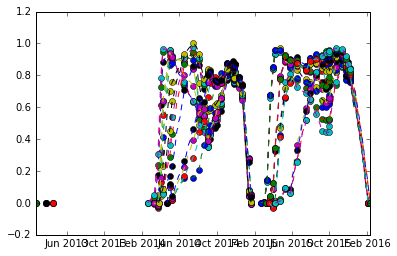

In [9]:
VarToInt = 'NDVISC'
InterpolationIndex = pd.MultiIndex.from_product([YearList,TreatmentList,MetData.ix['2013-02-01':].index], names=['year', 'TrtNum', 'Date'])
BiomassAnalysis = pd.DataFrame(index = InterpolationIndex, columns=[VarToInt])
for Year in [2013,2014,2015]:
    YearData = Data.ix[Data.YearSown==Year,:]
    YearIndex = GrandIndex.ix[Year,:].dropna(axis=1,how='all')
    for Treat in YearIndex.index:
        Filter = YearData.TrtNum == Treat
        TreatCover = YearData.ix[Filter,VarToInt].dropna().groupby(level='SampleDate').mean()
        plt.plot(TreatCover,'o')
        Dates = TreatCover.index
        ArrayTt = MetData.ix[Dates,'Tt']
        InterpDates = MetData.ix[Dates.min():Dates.max()].index
        dailyTt = MetData.ix[InterpDates,'Tt']
        InterpCover = np.interp(dailyTt,ArrayTt,TreatCover)
        TreatIndex = pd.MultiIndex.from_product([Year,Treat,InterpDates],names=['Year', 'TrtNum', 'Date'])
        InterpDF = pd.DataFrame(index = TreatIndex, data=InterpCover,columns=[VarToInt])
        plt.plot(InterpDates, InterpDF.ix[:,VarToInt],'--')
        BiomassAnalysis.update(InterpDF)

### Implement simple biomass model

In [10]:
BiomassAnalysis.dropna(inplace=True)
BiomassAnalysis.sort_index(inplace=True)
for Year in [2013,2014,2015]:
    YearData = Data.ix[Data.YearSown==Year,:]
    YearIndex = GrandIndex.ix[Year,:].dropna(axis=1,how='all')
    for Treat in YearIndex.index:
        Rad = MetData.ix[BiomassAnalysis.ix[(Year,Treat),:].index,'Radn']
        Temp = MetData.ix[BiomassAnalysis.ix[(Year,Treat),:].index,'MeanT']
        BiomassAnalysis.ix[(Year,Treat),'Radn'] = Rad.values
        BiomassAnalysis.ix[(Year,Treat),'Temp'] = Temp.values
BiomassAnalysis.ix[:,'IntRadn'] = BiomassAnalysis.ix[:,VarToInt] * BiomassAnalysis.ix[:,'Radn']
XTemp = [-10,0,15,25,35]
YRUE = [0,0,16,16,0]
BiomassAnalysis.ix[:,'RUE'] = [np.interp(BiomassAnalysis.ix[x,'Temp'],XTemp,YRUE) for x in BiomassAnalysis.index]
BiomassAnalysis.ix[:,'PotDM'] = BiomassAnalysis.ix[:,'RUE'] * BiomassAnalysis.ix[:,'IntRadn']

### Make a dataframe with indexing needed for doing harvest summary

In [11]:
Index = ['YearSown','SowingDate','Cultivar','PlantPopn','PGRCanopyMgmtTrt']
IndexedData = Data.set_index(Index)
IndexedData.sort_index(inplace=True)
#Filters for chosing data on specific harvests
GS65Filter = IndexedData.ix[:,'SampleGS']=='GS65'
GS90Filter = IndexedData.ix[:,'SampleGS']=='GS90'
#Calculate grain per gram of stem parameter
IndexedData.ix[GS90Filter,'GrainsPerGramStem'] = IndexedData.ix[GS90Filter,'GrainsMSq']/(IndexedData.ix[GS65Filter,'StemBiomass']/10)

## Time series graph

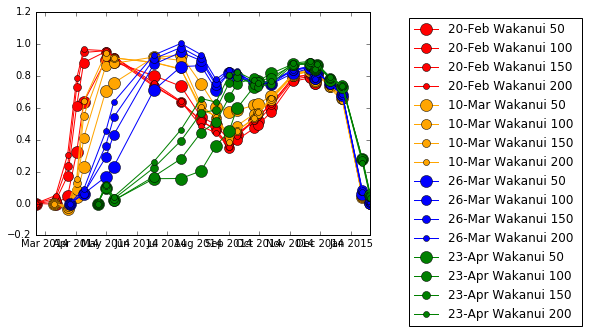

In [12]:
Year = 2014
Variable = 'NDVISC'
MakeTimeCoarseGraph(Year,Variable)

## Biomass model graph

(array([ 735293.,  735324.,  735354.,  735385.,  735415.,  735446.,
         735477.,  735507.,  735538.,  735568.,  735599.,  735630.]),
 <a list of 12 Text xticklabel objects>)

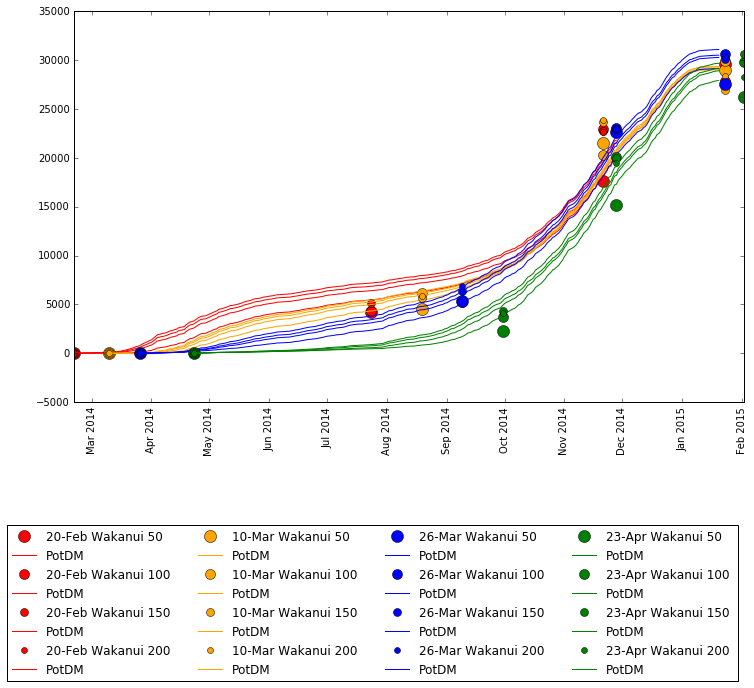

In [13]:
Year = 2014
GraphData = Data.ix[Data.YearSown==Year]
GraphTreats = GrandIndex.ix[Year,:].dropna(axis=1,how='all')
Demarkers = SetSymbols(GraphTreats)
Graph = plt.figure(figsize=(12,7))

for Treat in GraphTreats.index:
    Filter = (Data.YearSown == Year) & (Data.TrtNum == Treat)
    GraphData = Data.ix[Filter,'TotalBiomass'].dropna().groupby(level='SampleDate').mean()
    col = Demarkers[0][GraphTreats.ix[Treat][0]]
    mark = Demarkers[1][GraphTreats.ix[Treat][1]]
    try:
        size = Demarkers[2][GraphTreats.ix[Treat][2]]
    except:
        size = 8
    plt.plot(GraphData,mark,color = col, markersize = size,label = MakeLabel(GraphTreats.ix[Treat,:]))
    Potbiomass = BiomassAnalysis.ix[(Year,Treat),'PotDM'].cumsum()
    plt.plot(Potbiomass,'-', color=col)
plt.legend(bbox_to_anchor=(1, -0.3),numpoints=1,ncol=4)
plt.xticks(rotation=90)

## Harvest Graph

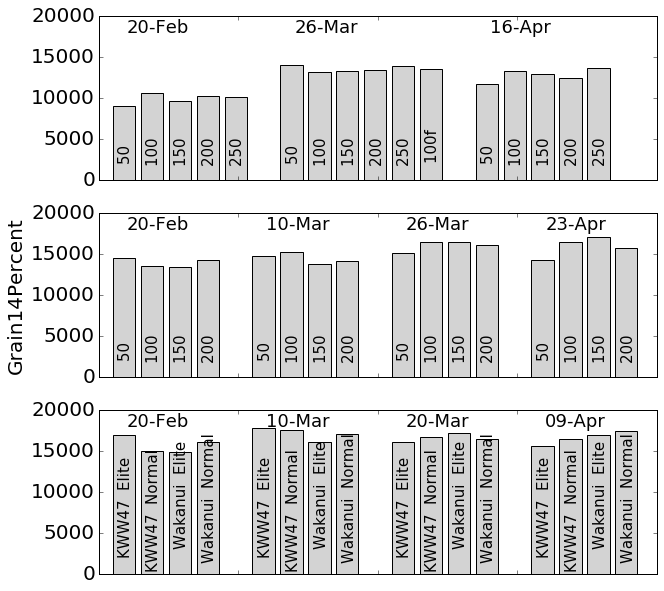

In [14]:
Variable = 'Grain14Percent'
MakeHarvestVariableGraph(Variable)

## Harvest correlations

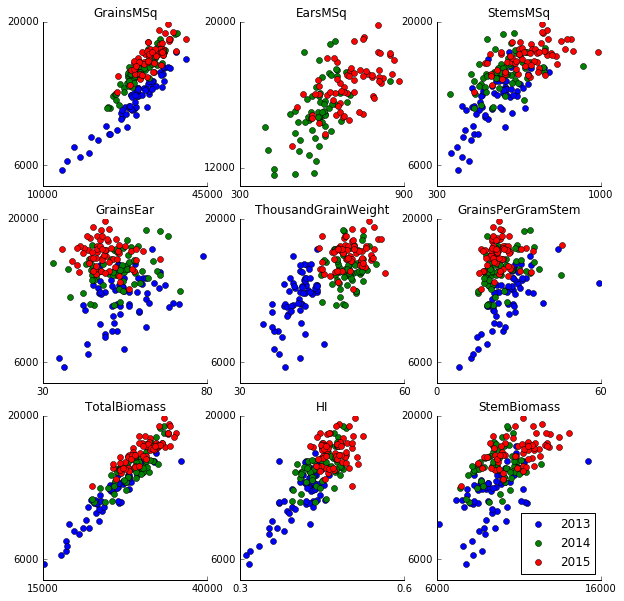

In [15]:
ComponentPairs = [['GrainsMSq','Grain14Percent'],
                  ['EarsMSq','Grain14Percent'],
                  ['StemsMSq','Grain14Percent'],
                  ['GrainsEar','Grain14Percent'],
                  ['ThousandGrainWeight','Grain14Percent'],
                  ['GrainsPerGramStem','Grain14Percent'],
                  ['TotalBiomass','Grain14Percent'],
                  ['HI','Grain14Percent'],
                  ['StemBiomass','Grain14Percent']]
Graph = plt.figure(figsize=(10,10))
pos = 1
for Component in ComponentPairs:
    Ax = Graph.add_subplot(3,3,pos)
    Ax.spines['right'].set_visible(False)
    Ax.spines['top'].set_visible(False)
    plt.tick_params(axis='x', which='both', bottom='on',top='off', labelbottom='on')
    plt.tick_params(axis='y', which='both', left='on',right='off', labelbottom='on')
    for Year in YearList:
        XData = IndexedData.ix[Year,Component[0]]
        YData = IndexedData.ix[Year,Component[1]]
        plt.plot(XData,YData,'o',label=Year)
        #plt.ylabel(Component[1])
        plt.title(Component[0])
    Ax.set_xticks([Ax.get_xticks()[0],Ax.get_xticks()[-1]])
    Ax.set_yticks([Ax.get_yticks()[1],Ax.get_yticks()[-1]])
    if pos == 9:
        plt.legend(loc=0,numpoints=1)
    pos+=1

## Single variable Harvest correlations

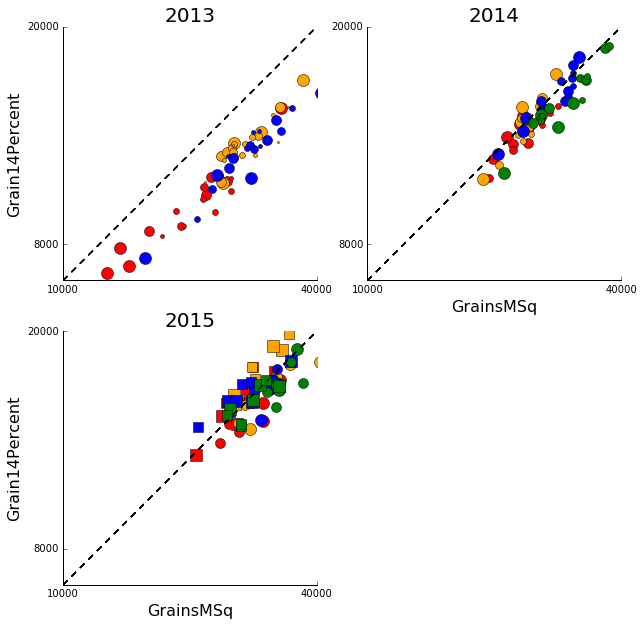

In [16]:
XVar = 'GrainsMSq'
YVar = 'Grain14Percent'
MakeSingleVariableRegression(XVar,YVar)